In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\German Credit\German_Credit_Ground_Truth.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   checking-account                       1000 non-null   int64
 1   duration                               1000 non-null   int64
 2   credit-history                         1000 non-null   int64
 3   purpose                                1000 non-null   int64
 4   credit-amount                          1000 non-null   int64
 5   savings-account                        1000 non-null   int64
 6   employment-since                       1000 non-null   int64
 7   installment-rate                       1000 non-null   int64
 8   other-debtors                          1000 non-null   int64
 9   residence-since                        1000 non-null   int64
 10  property                               1000 non-null   int64
 11  age                            

Learning the structure of the Bayesian Network...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 17/1000000 [00:01<32:37:59,  8.51it/s]


Bayesian Network Structure:
[('checking-account', 'class-label'), ('class-label', 'savings-account'), ('credit-history', 'other-installment'), ('employment-since', 'job'), ('job', 'telephone'), ('residence-since', 'employment-since'), ('residence-since', 'housing'), ('housing', 'property'), ('housing', 'sex'), ('property', 'other-debtors'), ('sex', 'marital-status'), ('sex', 'number-people-provide-maintenance-for'), ('existing-credits', 'credit-history'), ('telephone', 'foreign-worker'), ('number-people-provide-maintenance-for', 'marital-status')]


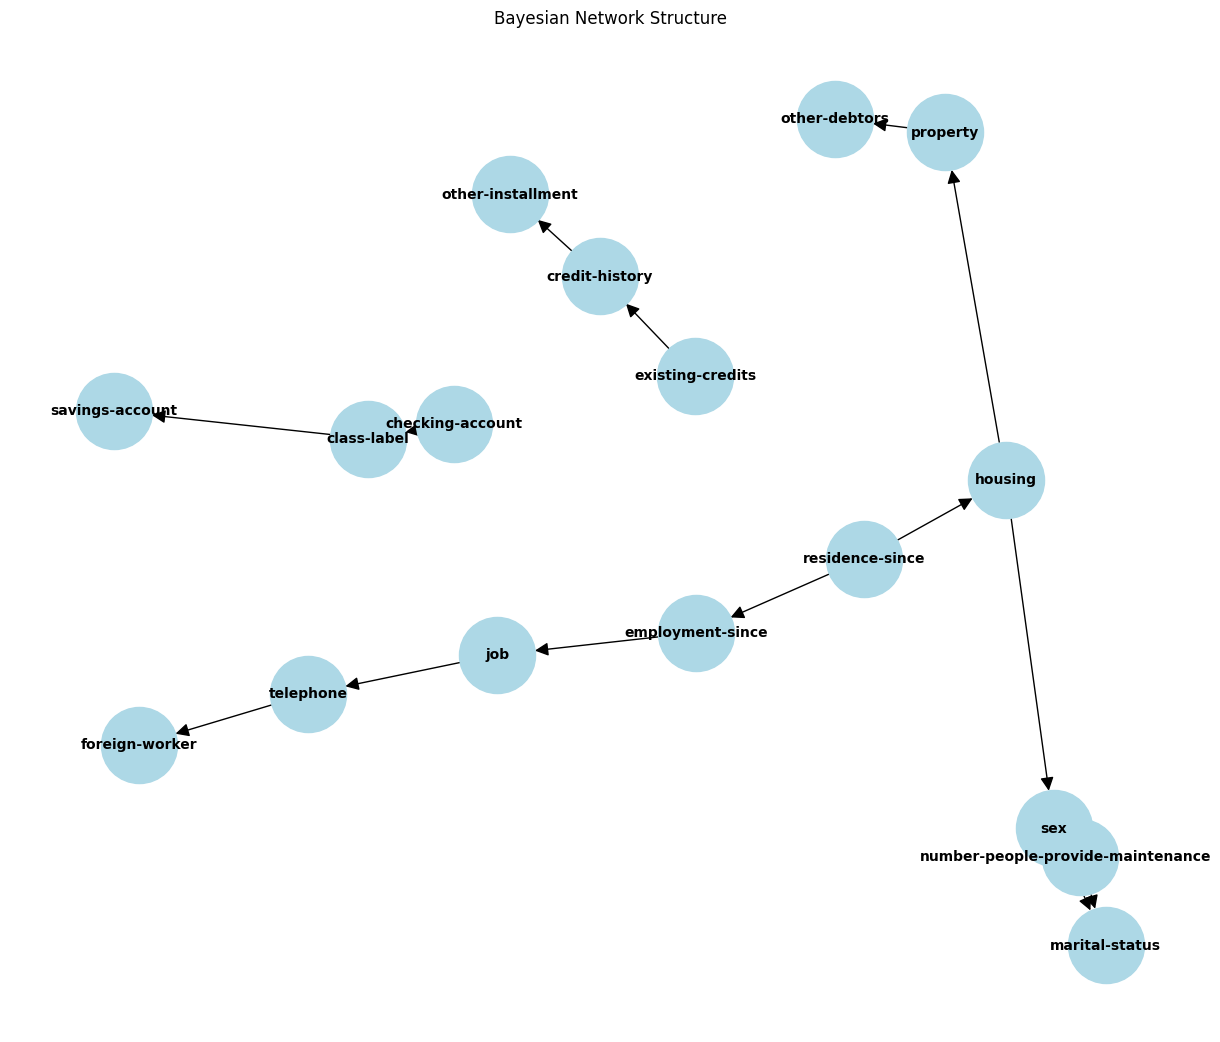

Fitting the Bayesian Network with data...


In [6]:


'''''
# Step 2: Identify missingness indicators
# Add missingness indicators for each column with missing values
missing_indicators = {}
for column in data.columns:
    if data[column].isnull().any():
        missing_indicators[f'R_{column}'] = data[column].isnull().astype(int)

# Add missingness indicators to the dataset
for key, value in missing_indicators.items():
    data[key] = value

# Drop rows with missing values temporarily for structure learning
'''''
data_complete = data.dropna()



# Step 3: Learn the structure of the Bayesian Network
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data_complete)
model = hc.estimate(scoring_method=BicScore(data_complete))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [8]:
inference = VariableElimination(bayesian_net)


# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["checking-account", "savings-account","class-label"])
print("\nJoint Probability")
print(query_result)



Joint Probability
+---------------------+--------------------+----------------+-----------------------------------------------------+
| checking-account    | savings-account    | class-label    |   phi(checking-account,savings-account,class-label) |
+=====================+====================+================+=====================================================+
| checking-account(0) | savings-account(0) | class-label(0) |                                              0.0119 |
+---------------------+--------------------+----------------+-----------------------------------------------------+
| checking-account(0) | savings-account(0) | class-label(1) |                                              0.0162 |
+---------------------+--------------------+----------------+-----------------------------------------------------+
| checking-account(0) | savings-account(1) | class-label(0) |                                              0.0038 |
+---------------------+--------------------+---------

In [10]:
result = inference.query(variables=["checking-account"], evidence={ "class-label": True})
print("Conditional Probability P(checking-account | class-label = True):")
print(result)

Conditional Probability P(checking-account | class-label = True):
+---------------------+-------------------------+
| checking-account    |   phi(checking-account) |
+=====================+=========================+
| checking-account(0) |                  0.2343 |
+---------------------+-------------------------+
| checking-account(1) |                  0.1986 |
+---------------------+-------------------------+
| checking-account(2) |                  0.0700 |
+---------------------+-------------------------+
| checking-account(3) |                  0.4971 |
+---------------------+-------------------------+


In [11]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['checking-account', 'class-label', 'credit-history', 'other-installment', 'employment-since', 'job', 'residence-since', 'housing', 'property', 'other-debtors', 'sex', 'existing-credits', 'telephone', 'number-people-provide-maintenance-for', 'marital-status', 'foreign-worker', 'savings-account']
Edges in the Bayesian Network:
[('checking-account', 'class-label'), ('class-label', 'savings-account'), ('credit-history', 'other-installment'), ('employment-since', 'job'), ('job', 'telephone'), ('residence-since', 'employment-since'), ('residence-since', 'housing'), ('housing', 'property'), ('housing', 'sex'), ('property', 'other-debtors'), ('sex', 'marital-status'), ('sex', 'number-people-provide-maintenance-for'), ('existing-credits', 'credit-history'), ('telephone', 'foreign-worker'), ('number-people-provide-maintenance-for', 'marital-status')]
